In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import importlib

import parameters as param
importlib.reload(param)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'parameters' from 'c:\\Users\\natha\\Desktop\\UCLA\\_Grad\\2025-2026\\FALL 2025\\MAE 263F\\MAE-263F\\final_report\\parameters.py'>

In [ ]:
class ContractionEngine:
    def __init__(self, n_segments, T_contraction, T_wave, Fmax, mu, sigma, pulse_type):
        self.n = n_segments
        self.T_contraction = T_contraction
        self.T_wave = T_wave

        # Contraction parameters
        self.Fmax = Fmax
        self.mu = mu
        self.sigma = sigma
        self.pulse_type = pulse_type

        # State arrays
        self.phase = np.zeros(n_segments, dtype=float)
        self.active = np.zeros(n_segments, dtype=bool)
        self.activated_this_wave = np.zeros(n_segments, dtype=bool)

    # Step 1: activate segments based on wave
    def set_activation_wave(self, t):
        scale = int(round(1 / param.dt))
        t_int, T_wave_int = int(round(t * scale)), int(round(self.T_wave * scale))
        phase_norm = np.mod(t_int, T_wave_int) / T_wave_int
        segment_pos = np.arange(self.n, dtype=float) / self.n

        for i, seg in enumerate(segment_pos):
            if (phase_norm >= seg) and (not self.activated_this_wave[i]):
                self.active[i] = True
                self.activated_this_wave[i] = True
                break  # only first segment

    # Step 2: increment phase and deactivate over-threshold segments
    def update_phase(self):
        self.phase[self.active] += param.dt
        self.phase[~self.active] = 0.0
        over_threshold = self.phase >= self.T_contraction
        self.phase[over_threshold] = 0.0
        self.active[over_threshold] = False

    # Step 3: pulse generator
    def pulse(self):
        if self.pulse_type == 'gaussian':
            return self.Fmax * np.exp(-0.5 * ((self.phase - self.mu) / self.sigma)**2)
        elif self.pulse_type == 'square':
            norm_phase = self.phase / self.T_contraction
            pulse_vals = np.zeros_like(self.phase)
            pulse_vals[norm_phase <= 0.2] = self.Fmax  # first 20% of contraction
            return pulse_vals
        elif self.pulse_type == 'dirac':
            pulse_vals = np.zeros_like(self.phase)
            pulse_vals[self.phase == 0.0] = self.Fmax  # instantaneous at start
            return pulse_vals
        else:
            raise ValueError("Unknown pulse type")

    # Step 4: compute forces for all segments
    def compute_forces(self):
        pulse_vals = self.pulse()
        pulse_vals[~self.active] = 0.0

        Fg = np.zeros(self.n * 2)
        Fg[0::2] = pulse_vals  # negative force
        Fg[1::2] = -pulse_vals   # positive force
        return Fg


# Test Running Engine

Time steps: 200
Activation history: (200, 6)
Force history: (200, 12)


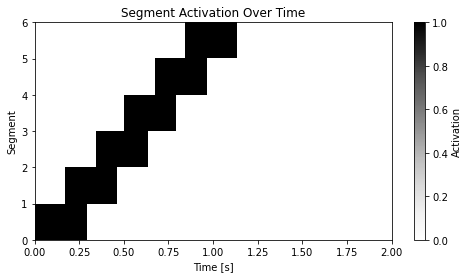

(200, 6)


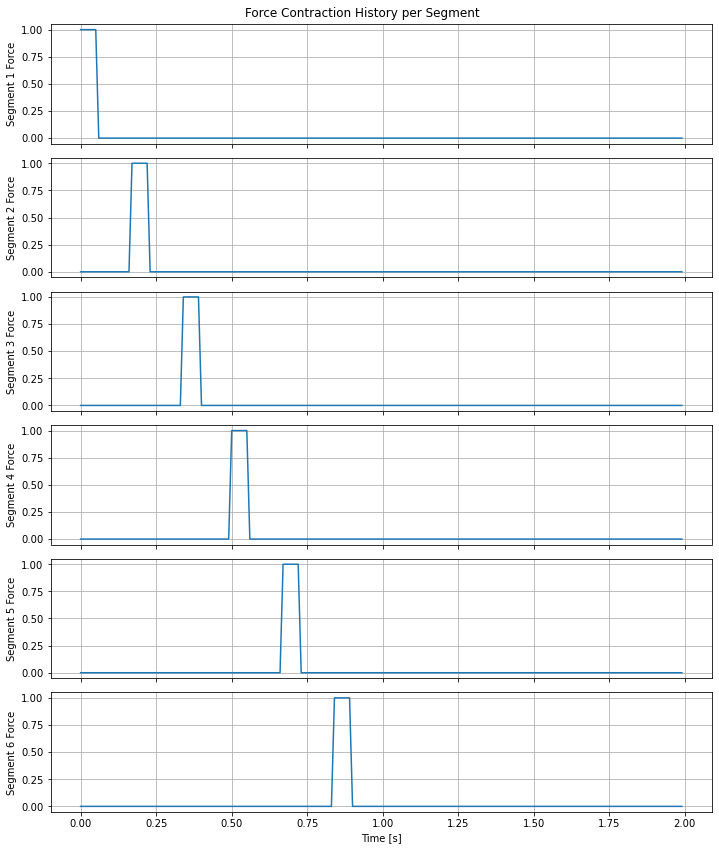

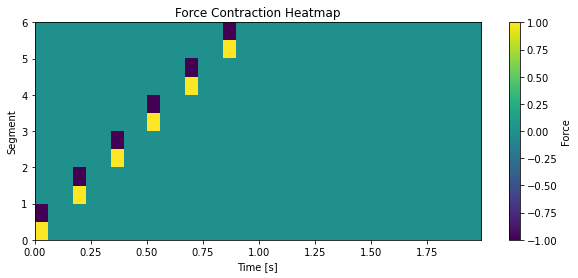

In [159]:
engine = ContractionEngine(
		n_segments=param.n,
		T_contraction=0.3,
		T_wave= 1.0,
		Fmax=1.0,
		mu=1.0,
		sigma=1.0,
    pulse_type='square'
)	

total_time = 2.0
time_array = np.arange(0,total_time, param.dt)
activation_history = []
force_history = []

for t in time_array:
	engine.set_activation_wave(t)
	engine.update_phase()
	forces = engine.compute_forces()
	force_history.append(forces.copy())
	activation_history.append(engine.active.copy())

print("Time steps:", len(time_array))
print(	"Activation history:", np.shape(activation_history))
print("Force history:", np.shape(force_history))

activation_history = np.array(activation_history, dtype=int)  # shape: (time_steps, n_segments)
plt.figure(figsize=(8,4))
plt.imshow(activation_history.T, aspect='auto', origin='lower',
           extent=[0, total_time, 0, 6], cmap='Greys', interpolation='none')
plt.colorbar(label='Activation')
plt.xlabel('Time [s]')
plt.ylabel('Segment')
plt.title('Segment Activation Over Time')
plt.show()

force_history = np.array(force_history, dtype=float)
force_history_pos = force_history[:, 0::2]  # start at index 1, step by 2
print(force_history_pos.shape)  # should be (time_steps, n_segments)

fig, axs = plt.subplots(param.n, 1, figsize=(10, 2*param.n), sharex=True)
for i in range(param.n):
    axs[i].plot(time_array, force_history_pos[:, i])
    axs[i].set_ylabel(f'Segment {i+1} Force')
    axs[i].grid(True)
axs[-1].set_xlabel('Time [s]')
plt.suptitle('Force Contraction History per Segment')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(force_history.T, aspect='auto', origin='lower',
           extent=[0, time_array[-1], 0, param.n],
           cmap='viridis', interpolation='none')
plt.colorbar(label='Force')
plt.xlabel('Time [s]')
plt.ylabel('Segment')
plt.title('Force Contraction Heatmap')
plt.show()




# Tests

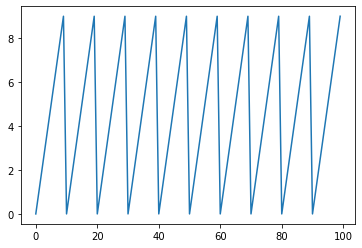

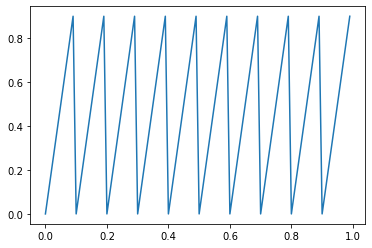

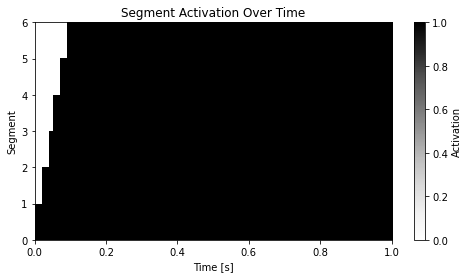

In [138]:
T_wave = 0.10	# period of full contraction wave
total_time = 1.0
t = np.arange(0.0, total_time, param.dt)

# convert time to integer representation for modulo operations
scale = int(round(1/param.dt))  # scale = 100
t_int = np.zeros(len(t), dtype=int)
for i in range(len(t)):
		t_int[i] = int(round(t[i] * scale))  # integer time
T_wave_int = int(round(T_wave * scale))    # integer wave period
wave = np.mod(t_int , T_wave_int) # wave phase in integer representation
phase_norm = (wave / T_wave_int) # normalized wave phase [0, 1]

segment_pos = np.arange(6) / 6
#print(segment_pos)

plt.figure()
plt.plot(t_int, wave, label='Wave Phase Norm')
plt.figure()
plt.plot(t, phase_norm, label='Wave Phase Norm')


# track if segment has already been activated in this wave
active = np.zeros(6, dtype=bool)
activated_this_wave = np.zeros(6, dtype=bool)
activation_history = []

for step, phase in enumerate(phase_norm):
	# check which segments the wave pointer has passed
	for i, seg in enumerate(segment_pos):
		#if (not activated_this_wave[i]) and (phase >= seg):
		if (phase >= seg):
			#print(f"phase: {phase}, seg: {seg}, i: {i}")
			active[i] = True                # first activation
			activated_this_wave[i] = True   # mark as triggered
	activation_history.append(active.copy())

#print(activation_history)
activation_history = np.array(activation_history, dtype=int)  # shape: (time_steps, n_segments)
#print(activation_history)

plt.figure(figsize=(8,4))
plt.imshow(activation_history.T, aspect='auto', origin='lower',
           extent=[0, total_time, 0, 6], cmap='Greys', interpolation='none')
plt.colorbar(label='Activation')
plt.xlabel('Time [s]')
plt.ylabel('Segment')
plt.title('Segment Activation Over Time')
plt.show()


